In this notebook we will predict the energy consumption(KWH) based on the other available features in our dataset which is located here:

https://www.eia.gov/consumption/residential/data/2009/index.php?view=mic

Since we are trying to predict a continous variable(KWH) we will need to use a regression based model that can handle a huge dataset with many features and avoid overfitting and provide us with some hyperparamers to tune the model. In this case, i have decided to use XGBregressor as it provides several parameters such as lambda and gamma to avoid overfitting and underfitting and also adjust the effect of significant values.

Let's import some packages and read in the data:

In [ ]:
from pmdarima import auto_arima
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
import numpy as np
from numpy import sort
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import seaborn as sns
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

In [370]:
data = pd.read_csv('recs2009_public.csv', parse_dates= True)

In [371]:
data

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,-2,5A,2251,0,5426,0.61,4,50,13,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,12079,2,3,9,2,10219.80,7671,332,7784,451,...,-2,6A-6B,4289,39,7819,0.59,0,48,-3,84
12079,12080,3,7,21,4,8689.07,2085,2844,2520,2286,...,-2,3B-4B,360,393,1869,0.50,0,56,26,101
12080,12081,2,4,10,2,4697.21,7935,472,8074,600,...,-2,6A-6B,4494,22,8477,0.58,1,46,-9,89
12081,12082,4,8,23,2,13155.68,5834,770,5989,957,...,-2,5B-5C,2840,0,9010,0.54,1,53,13,93


In [270]:
sum(data.isnull().any())

0

There is no Null values in our dataset! However we need to handle the categorical variables and make some dummies out of them. on some columns we have both string and numeric elemnts we need to change them to numeric.

In [271]:
data.dtypes.value_counts()

int64      885
float64     50
object       5
dtype: int64

In [272]:
cat_col = [col for col in data.columns if data[col].dtype =="object"]

In [273]:
cat_col

['METROMICRO', 'UR', 'NOCRCASH', 'NKRGALNC', 'IECC_Climate_Pub']

In [274]:
data['NOCRCASH'].unique()

array([-2, 1, 6, 15, 4, '-2', '1', '20', '.', '12', '4', '10', '3', '24',
       '55', '6', 8, 28, 5, 55, 3, 16, 2, 20, 10, 24, 40, 12, 25],
      dtype=object)

In [275]:
data['IECC_Climate_Pub'].unique()

array(['4A', '3C', '5A', '6A-6B', '1A-2A', '3B-4B', '3A', '5B-5C',
       '7A-7B-7AK-8AK', '2B', '4C'], dtype=object)

In [276]:
data['NKRGALNC'].unique()

array([-2, 1, 5, 10, '-2', '10', '15', '1', '8', '.', '5', '3', '2', '77',
       30, 3, 15, 8, 55, 2, 20], dtype=object)

In [277]:
data = data[(data['NKRGALNC'] != '.') | (data['NOCRCASH'] != '.')]

In [278]:
data['NOCRCASH']= pd.to_numeric(data['NOCRCASH'])
data['NKRGALNC']= pd.to_numeric(data['NKRGALNC'])

In [280]:
cat_col = [col for col in data.columns if data[col].dtype =="object"]

In [281]:
cat_col

['METROMICRO', 'UR', 'IECC_Climate_Pub']

In [282]:
def cat_to_num(cat_col, data):
    for col in cat_col:
        dummied = pd.get_dummies(data[col])
        data = pd.concat([data.drop(col, axis = 1), dummied] ,axis = 1)
    return data
data = cat_to_num(cat_col,data)


In [283]:
data.dtypes.value_counts()

int64      887
float64     50
uint8       16
dtype: int64

## Let's examine the distribution of our target variable to spot the outliers

<AxesSubplot:xlabel='KWH'>

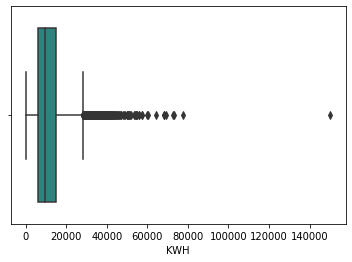

In [284]:
# data['KWH'].plot()
import math
sns.boxplot(data=data,  x='KWH', palette='viridis')

## Looking at 25th and 75th percentiles we see that most of our data lays between 5.8k and 14.7k and we can easily observe many outliers if we calculate the IQR *1.5 + 75th percentile so here i have decided to remove anything greater than 40000 to not lose to much info.

In [285]:
data['KWH'].describe().apply(lambda x: format(x, 'f'))

count     12081.000000
mean      11289.533068
std        7641.077130
min          17.000000
25%        5841.000000
50%        9623.000000
75%       14768.000000
max      150254.000000
Name: KWH, dtype: object

In [286]:
data = data[data['KWH'] <40000]

In [287]:
data.columns.value_counts()

MICRO          2
GARGLOC        1
ZTEMPNITEAC    1
FUELPOOL       1
3C             1
              ..
ZTYPECLN       1
ZUSENGFP       1
HELPCW         1
CHRGPLGE       1
OUTLET         1
Length: 952, dtype: int64

In [288]:
data['MICRO1'] = data['MICRO'].iloc[:,0]
data.drop('MICRO', axis = 1, inplace = True)

## We are going to use a special method called wrapper to select usefull features out of our huge dataset, so we first train the XGB with the whole dataset to capture the feature importances(gain from each feature) and then using the built in class of "SelectFromModel" in XGB with a certaing threshhold we pick the right features that our model gain the most info from.

In [290]:

X = data.drop(['KWH', 'DOEID'], axis = 1)
# X = data[['DIVISION', 'REGIONC','TYPEHUQ','NWEIGHT','HDD30YR']]
Y = data['KWH']
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
# fit model on all training data
model = XGBRegressor()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = metrics.mean_absolute_error(y_test, predictions)
# Fit model using each importance as a threshold
thresholds = sorted(model.feature_importances_, reverse=True)
for thresh in thresholds:
    if thresh > 0:
        # select features using threshold
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
        # train model
        selection_model = XGBRegressor()
        selection_model.fit(select_X_train, y_train)
        # eval model
        select_X_test = selection.transform(X_test)
        y_pred = selection_model.predict(select_X_test)
        predictions = [round(value) for value in y_pred]
        accuracy = metrics.mean_absolute_error(y_test, predictions)
        if select_X_train.shape[1] < 30:
            print("Thresh=%.12f, n=%d, MAE: %.2f" % (thresh, select_X_train.shape[1], accuracy))
        elif select_X_train.shape[1] % 100 == 0:
            print("Thresh=%.10f, n=%d, MAE: %.2f" % (thresh, select_X_train.shape[1], accuracy))

Thresh=0.994122385979, n=1, MAE: 13.75
Thresh=0.000494635780, n=2, MAE: 14.09
Thresh=0.000294105004, n=3, MAE: 14.27
Thresh=0.000190245031, n=4, MAE: 14.64
Thresh=0.000156704002, n=5, MAE: 14.46
Thresh=0.000115859679, n=6, MAE: 14.59
Thresh=0.000097834134, n=7, MAE: 15.48
Thresh=0.000096075943, n=8, MAE: 15.73
Thresh=0.000076290424, n=9, MAE: 14.92
Thresh=0.000059029157, n=10, MAE: 15.36
Thresh=0.000054499043, n=11, MAE: 15.01
Thresh=0.000053412732, n=12, MAE: 15.69
Thresh=0.000053268530, n=13, MAE: 15.62
Thresh=0.000049350576, n=14, MAE: 15.73
Thresh=0.000046925004, n=15, MAE: 15.79
Thresh=0.000046882080, n=16, MAE: 15.79
Thresh=0.000046355381, n=17, MAE: 16.34
Thresh=0.000044920096, n=18, MAE: 16.87
Thresh=0.000044551562, n=19, MAE: 16.52
Thresh=0.000043389362, n=20, MAE: 16.73
Thresh=0.000041283041, n=21, MAE: 17.06
Thresh=0.000040268227, n=22, MAE: 18.04
Thresh=0.000039258419, n=23, MAE: 18.39
Thresh=0.000037624821, n=24, MAE: 18.46
Thresh=0.000037391455, n=25, MAE: 17.87
Thresh=0.

## So here as seen, from n=1 to n=6 we are obsering a very low MAE and the gap between these MAEs are very small so here i have made a trade-off by choosing the n=6 which has a lower MAE compared to n=1 to generalize our model for the future and unseen data.

In [292]:
feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

feat_imp_df = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

In [293]:
sum(feat_imp_df['score']>20)

438

In [294]:
feat_imp_df

,score
BTUEL,9.330328e+08
HELPWS,4.642400e+05
HELPCWY,2.760320e+05
ESFRIG3,1.785543e+05
KAVALEL,1.470744e+05
...,...
BASEHEAT,3.685981e+02
FREEZER,3.538369e+02
FUELFOOD,2.445312e+02
STOVE,3.221445e+01


## Now let's train our model using the selected features that we found from the previous step and apply a cross validation method to fidn the right parameters of our model to further improve our model.

In [365]:
import xgboost as xgb
data_dmatrix = xgb.DMatrix(data=select_X_train,label=y_train)
grid = pd.DataFrame({'eta':[0.299,0.3001,0.301,0.3]*2,
'subsample':np.repeat([0.95,1],4)})
def fit(x):
    params = {'objective':'reg:squarederror',
              'eval_metric':'logloss',
              'eta':x[0],
              'subsample':x[1]}
    xgb_cv = xgb.cv(dtrain=data_dmatrix, params=params, 
    nfold=5, metrics = 'logloss',seed=42)
    return xgb_cv[-1:].values[0]

grid[['train-logloss-mean','train-logloss-std',
'test-logloss-mean','test-logloss-std']] = grid.apply(fit,axis=1,result_type='expand')


In [366]:
grid

,eta,subsample,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.2990,0.95,-408588.26875,1096.962919,-408587.93750,4386.879811
1,0.3001,0.95,-408588.23750,1096.918619,-408587.88750,4386.886565
2,0.3010,0.95,-408588.26875,1096.972538,-408587.95625,4386.902120
3,0.3000,0.95,-408588.30000,1096.901749,-408587.93125,4386.867289
4,0.2990,1.00,-408588.28125,1096.960377,-408587.96875,4386.922022
5,0.3001,1.00,-408588.24375,1096.979952,-408587.93125,4386.929634
6,0.3010,1.00,-408588.20000,1096.954316,-408587.92500,4386.912440
7,0.3000,1.00,-408588.23125,1096.964927,-408587.91875,4386.917720


As we can see, row 5 has the best scores so we will retrain our model using those parameteres.

In [368]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror',
                           eval_metric = 'logloss',
                           eta = 0.3001,
                           subsample = 1)

xgb_reg.fit(select_X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.3001, eval_metric='logloss', gamma=0, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.300099999, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=96, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [373]:
select_X_test = selection.transform(X_test)
y_pred = xgb_reg.predict(select_X_test)
predictions = [round(value) for value in y_pred]
accuracy = metrics.mean_absolute_error(y_test, predictions)
print("Thresh=%.3f, n=%d, Accuracy: %.2f" % (thresh, select_X_train.shape[1], accuracy))

Thresh=0.000, n=6, Accuracy: 14.24


# Great! we were abale to both select the best features and also we were able to improve the MAE further!